In [2]:
%load_ext lab_black

In [3]:
%matplotlib inline
import torch
import torch.nn as nn
import numba
import numpy as np
import matplotlib.pyplot as plt

In [4]:
device = "cuda:1"

In [5]:
spec = [
    ("solved", numba.types.boolean),
    ("g", numba.types.float64),
    ("mu", numba.types.float64),
    ("__v_no_drag", numba.types.float64[:, :]),
    ("__v", numba.types.float64[:, :]),
    ("__y_no_drag", numba.types.float64[:, :]),
    ("__y", numba.types.float64[:, :]),
    ("__t", numba.types.float64[:]),
]


@numba.jitclass(spec)
class ODEData:  # torch.utils.data.Dataset):
    def __init__(self, g=9.81, mu=0):
        self.solved = False
        self.g = g
        self.mu = mu

    def __getitem__(self, i):
        if not self.solved:
            raise RuntimeError("Please run solve() first!")
        return self.y_no_drag[i], self.y[i]

    def solve(self, v0, y0, t, dt):
        N = int(t // dt + 1)
        np.zeros((N, len(v0)))
        self.__v_no_drag = np.zeros((N, len(v0)))
        self.__y_no_drag = np.zeros_like(self.__v_no_drag)
        self.__v = np.zeros_like(self.__v_no_drag)
        self.__y = np.zeros_like(self.__v_no_drag)
        self.__v_no_drag[0] = v0
        self.__v[0] = v0
        self.__y_no_drag[0] = y0
        self.__y[0] = y0
        self.__t = np.linspace(0, t, N)
        for i in range(N - 1):
            a_pull = -self.g * self.__y[i]
            a_drag = self.mu * self.__v[i]
            a_pull_no_drag = -self.g * self.__y_no_drag[i]
            step = a_pull_no_drag * dt
            self.__v_no_drag[i + 1] = self.__v_no_drag[i] + step * (step < 0)
            step = (a_pull - a_drag) * dt
            self.__v[i + 1] = self.__v[i] + step * (step < 0)
            step = self.__y_no_drag[i] + self.__v_no_drag[i + 1] * dt
            self.__y_no_drag[i + 1] = step * (step > 0)
            step = self.__y[i] + self.__v[i + 1] * dt
            self.__y[i + 1] = step * (step > 0)
        self.solved = True

    @property
    def y(self):
        return self.__y

    @property
    def y_no_drag(self):
        return self.__y_no_drag

    @property
    def v(self):
        return self.__v

    @property
    def v_no_drag(self):
        return self.__v_no_drag

    @property
    def t(self):
        return self.__t

    @property
    def size(self):
        return len(self.__t)

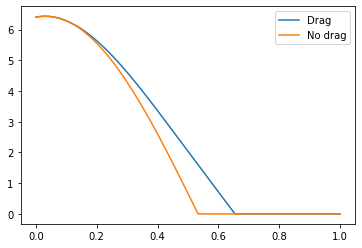

In [64]:
data = ODEData(mu=2)
batch_size = 100
t = 1
dt = 5e-4
v0 = np.random.uniform(0, 5, size=batch_size)
y0 = np.random.uniform(0, 10, size=batch_size)
data.solve(v0, y0, t, dt)
plt.plot(data.t, data.y[:, 0], label="Drag")
plt.plot(data.t, data.y_no_drag[:, 0], label="No drag")
plt.legend()
plt.show()

In [65]:
class HybridLSTM(nn.Module):
    def __init__(self, nodes=10, layers=1, dropout=0):
        super(HybridLSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=1, hidden_size=nodes, num_layers=layers, dropout=dropout
        )
        self.output_layer = nn.Linear(nodes, 1)

    def forward(self, y):
        output, (h_n, c_n) = self.lstm(y)
        return self.output_layer(output)

In [66]:
def train(net, data, epochs=10, lr=0.1, mom=0):
    $optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=mom)
    loss_func = nn.MSELoss()
    y_no_drag = (
        torch.from_numpy(data.y_no_drag.reshape(-1, 1)[:, :, np.newaxis])
        .float()
        .to(device)
    )
    y = torch.from_numpy(data.y.reshape(-1, 1)[:, :, np.newaxis]).float().to(device)
    net.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = net.forward(y_no_drag)
        loss = loss_func(y_pred, y)
        print(f"Epoch {epoch} loss: {loss.item()}")
        loss.backward()
        optimizer.step()
        print(
            f"Using {torch.cuda.memory_allocated(device) / (1024**2):.0f} MB of {torch.cuda.max_memory_allocated(device) / (1024**2):.0f} MB VRAM available. \n"
        )
    del y
    del y_no_drag
    del loss
    del optimizer

In [67]:
net = HybridLSTM(nodes=51, layers=1).to(device)
train(net, data, epochs=100, lr=0.1, mom=0.8)

Epoch 0 loss: 10.715531349182129
Using 26 MB of 3147 MB VRAM available. 

Epoch 1 loss: 5.546682357788086
Using 26 MB of 3147 MB VRAM available. 

Epoch 2 loss: 2.4008266925811768
Using 26 MB of 3147 MB VRAM available. 

Epoch 3 loss: 4.960474967956543
Using 26 MB of 3147 MB VRAM available. 

Epoch 4 loss: 1.1374380588531494
Using 26 MB of 3147 MB VRAM available. 

Epoch 5 loss: 1.8799192905426025
Using 26 MB of 3147 MB VRAM available. 

Epoch 6 loss: 0.6656728982925415
Using 26 MB of 3147 MB VRAM available. 

Epoch 7 loss: 1.0263034105300903
Using 26 MB of 3147 MB VRAM available. 

Epoch 8 loss: 0.43720749020576477
Using 26 MB of 3147 MB VRAM available. 

Epoch 9 loss: 0.3868555426597595
Using 26 MB of 3147 MB VRAM available. 

Epoch 10 loss: 0.4900238811969757
Using 26 MB of 3147 MB VRAM available. 

Epoch 11 loss: 0.29991424083709717
Using 26 MB of 3147 MB VRAM available. 

Epoch 12 loss: 0.37255987524986267
Using 26 MB of 3147 MB VRAM available. 

Epoch 13 loss: 0.36363571882247925

In [68]:
def predict(net, y_no_drag):
    with torch.no_grad():
        y_pred = net.forward(y_no_drag)
    return y_pred

In [69]:
y_no_drag = torch.from_numpy(data.y_no_drag[:, :, np.newaxis]).to(device).float()
y_pred = predict(net, y_no_drag).cpu()

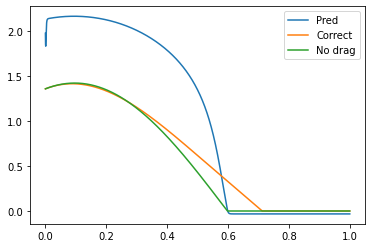

In [95]:
batch_plot = np.random.randint(batch_size)
plt.plot(data.t, y_pred[:, batch_plot, 0], label="Pred")
plt.plot(data.t, data.y[:, batch_plot], label="Correct")
plt.plot(data.t, data.y_no_drag[:, batch_plot], label="No drag")
plt.legend()
plt.show()

# TODO: 

Try different optimizer. This should be able to overfit even if it doesnt properly explain the physics.
Implement dataparalell to use both GPUS!

Create a purely data driven model using position, velocity and perhaps acceleration as inputs. 

Perhaps implement the ODE model 